**Name:** SIVAKUMAR Srinivas

**EID:** ssivakuma2

# CS4487 - Tutorial 4
## Face Detection in Images

In this tutorial you will train a classifier to detect whether there is a face in a small image patch.  This type of face detector is used in your phone and camera whenever you take a picture!

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
from scipy import ndimage
from scipy import signal
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [2]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 4  
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile)
            # convert to grayscale
            img = skimage.color.rgb2gray(img)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

1745
944


Each image is a 19x19 array of pixel values.  Run the below code to show an example:

(19, 19)


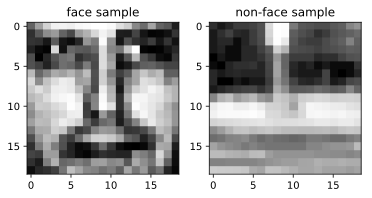

In [3]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(imgdata['train'][0], cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(imgdata['train'][trainclass2start], cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

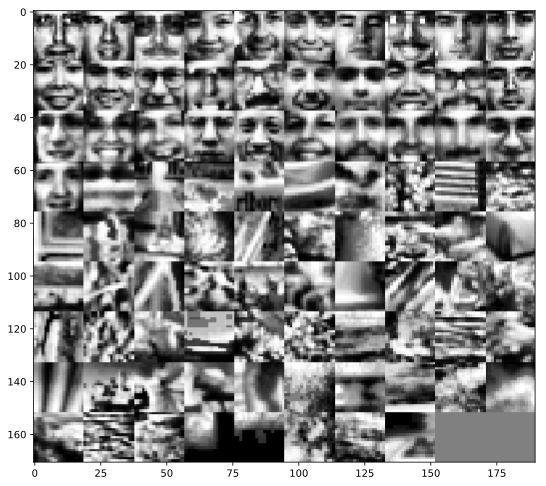

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show a few images
plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata['train'][::20]), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [5]:
trainX = empty((len(imgdata['train']), prod(imgsize)))
for i,img in enumerate(imgdata['train']):
    trainX[i,:] = ravel(img)
trainY = asarray(classes['train'])  # convert list to numpy array
print(trainX.shape)
print(trainY.shape)

testX = empty((len(imgdata['test']), prod(imgsize)))
for i,img in enumerate(imgdata['test']):
    testX[i,:] = ravel(img)
testY = asarray(classes['test'])  # convert list to numpy array
print(testX.shape)
print(testY.shape)

(1745, 361)
(1745,)
(944, 361)
(944,)


## 2. Detection using  pixel values

Train an AdaBoost classifier to classify an image patch as face or non-face.  Also train a kernel SVM classifier using either RBF or polynomial kernel, and a Random Forest Classifier.  Evaluate all your classifiers on the test set.

Don't forget to normalize your features!

In [6]:
# Using Standard Scaler
scaler = preprocessing.StandardScaler()
trainXn = scaler.fit_transform(trainX)
testXn = scaler.transform(testX)

In [7]:
paramgrid = {'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000,2000]) }
adacv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(random_state=4487),
                                 paramgrid, cv=5, n_jobs=10, verbose=1)
adacv.fit(trainXn, trainY)

print("best params:", adacv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.7s
[Parallel(n_jobs=10)]: Done  70 out of  70 | elapsed:  3.4min finished


best params: {'n_estimators': 1000}


In [8]:
predY = adacv.predict(testXn)
acc = metrics.accuracy_score(testY, predY)
print("adaboost test accuracy =", acc)

adaboost test accuracy = 0.6260593220338984


In [9]:
paramgrid ={'C': logspace(-2,3,10), 'degree': [2, 3, 4] }
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='poly'),paramgrid, cv = 5,verbose = 1)
svmcv.fit(trainXn,trainY)
print("best params:", svmcv.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.1min finished


best params: {'C': 1.6681005372000592, 'degree': 3}


In [10]:
predY = svmcv.predict(testXn)
acc = metrics.accuracy_score(testY, predY)
print("polynomial svm test accuracy =", acc)

polynomial svm test accuracy = 0.701271186440678


In [11]:
paramgrid = {'C': logspace(-2,3,10), 'gamma': logspace(-4,3,10) }
rbfcv = model_selection.GridSearchCV(svm.SVC(kernel='rbf'),paramgrid, cv = 5,verbose = 1, n_jobs = 10)
rbfcv.fit(trainXn,trainY)
print("best params:", rbfcv.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] gamma=0.0001, C=0.01 ............................................
[CV] gamma=0.0001, C=0.01 ............................................
[CV] gamma=0.0001, C=0.01 ............................................
[CV] gamma=0.0001, C=0.01 ............................................
[CV] gamma=0.0001, C=0.01 ............................................
[CV] gamma=0.0005994842503189409, C=0.01 .............................
[CV] gamma=0.0005994842503189409, C=0.01 .............................
[CV] gamma=0.0005994842503189409, C=0.01 .............................
[CV] gamma=0.0005994842503189409, C=0.01 .............................
[CV] gamma=0.0005994842503189409, C=0.01 .............................
[CV] ............................. gamma=0.0001, C=0.01, total=   1.3s
[CV] gamma=0.003593813663804626, C=0.01 ..............................
[CV] .............. gamma=0.0005994842503189409, C=0.01, total=   1.2s
[CV] gamma=0.0

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.7s


[CV] ................. gamma=0.1291549665014884, C=0.01, total=   1.2s
[CV] gamma=4.641588833612782, C=0.01 .................................
[CV] .................. gamma=0.774263682681127, C=0.01, total=   1.2s
[CV] .................. gamma=0.774263682681127, C=0.01, total=   1.2s
[CV] gamma=27.825594022071257, C=0.01 ................................
[CV] gamma=27.825594022071257, C=0.01 ................................
[CV] .................. gamma=0.774263682681127, C=0.01, total=   1.2s
[CV] gamma=27.825594022071257, C=0.01 ................................
[CV] .................. gamma=0.774263682681127, C=0.01, total=   1.2s
[CV] gamma=27.825594022071257, C=0.01 ................................
[CV] .................. gamma=0.774263682681127, C=0.01, total=   1.2s
[CV] gamma=27.825594022071257, C=0.01 ................................
[CV] .................. gamma=4.641588833612782, C=0.01, total=   1.1s
[CV] gamma=166.81005372000593, C=0.01 ................................
[CV] .

[CV] ... gamma=4.641588833612782, C=0.03593813663804628, total=   1.1s
[CV] gamma=166.81005372000593, C=0.03593813663804628 .................
[CV] ... gamma=4.641588833612782, C=0.03593813663804628, total=   1.1s
[CV] gamma=166.81005372000593, C=0.03593813663804628 .................
[CV] ... gamma=4.641588833612782, C=0.03593813663804628, total=   1.1s
[CV] gamma=166.81005372000593, C=0.03593813663804628 .................
[CV] .. gamma=27.825594022071257, C=0.03593813663804628, total=   1.1s
[CV] gamma=1000.0, C=0.03593813663804628 .............................
[CV] .. gamma=27.825594022071257, C=0.03593813663804628, total=   1.1s
[CV] gamma=1000.0, C=0.03593813663804628 .............................
[CV] .. gamma=27.825594022071257, C=0.03593813663804628, total=   1.1s
[CV] gamma=1000.0, C=0.03593813663804628 .............................
[CV] .. gamma=27.825594022071257, C=0.03593813663804628, total=   1.1s
[CV] gamma=1000.0, C=0.03593813663804628 .............................
[CV] .

[CV] ... gamma=166.81005372000593, C=0.1291549665014884, total=   1.1s
[CV] gamma=0.0001, C=0.464158883361278 ...............................
[CV] ... gamma=166.81005372000593, C=0.1291549665014884, total=   1.1s
[CV] gamma=0.0001, C=0.464158883361278 ...............................
[CV] ... gamma=166.81005372000593, C=0.1291549665014884, total=   1.1s
[CV] gamma=0.0001, C=0.464158883361278 ...............................
[CV] ... gamma=166.81005372000593, C=0.1291549665014884, total=   1.1s
[CV] gamma=0.0001, C=0.464158883361278 ...............................


[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   27.0s


[CV] ... gamma=166.81005372000593, C=0.1291549665014884, total=   1.1s
[CV] gamma=0.0001, C=0.464158883361278 ...............................
[CV] ................ gamma=0.0001, C=0.464158883361278, total=   0.5s
[CV] gamma=0.0005994842503189409, C=0.464158883361278 ................
[CV] ................ gamma=0.0001, C=0.464158883361278, total=   0.6s
[CV] gamma=0.0005994842503189409, C=0.464158883361278 ................
[CV] ................ gamma=0.0001, C=0.464158883361278, total=   0.6s
[CV] gamma=0.0005994842503189409, C=0.464158883361278 ................
[CV] ................ gamma=0.0001, C=0.464158883361278, total=   0.6s
[CV] gamma=0.0005994842503189409, C=0.464158883361278 ................
[CV] . gamma=0.0005994842503189409, C=0.464158883361278, total=   0.3s
[CV] gamma=0.0005994842503189409, C=0.464158883361278 ................
[CV] ............... gamma=1000.0, C=0.1291549665014884, total=   1.1s
[CV] gamma=0.003593813663804626, C=0.464158883361278 .................
[CV] .

[CV]  gamma=0.0005994842503189409, C=1.6681005372000592, total=   0.2s
[CV] gamma=0.003593813663804626, C=1.6681005372000592 ................
[CV]  gamma=0.0005994842503189409, C=1.6681005372000592, total=   0.2s
[CV] gamma=0.003593813663804626, C=1.6681005372000592 ................
[CV]  gamma=0.0005994842503189409, C=1.6681005372000592, total=   0.2s
[CV] gamma=0.003593813663804626, C=1.6681005372000592 ................
[CV] . gamma=0.003593813663804626, C=1.6681005372000592, total=   0.3s
[CV] gamma=0.021544346900318846, C=1.6681005372000592 ................
[CV] . gamma=0.003593813663804626, C=1.6681005372000592, total=   0.3s
[CV] gamma=0.021544346900318846, C=1.6681005372000592 ................
[CV] ................ gamma=1000.0, C=0.464158883361278, total=   1.1s
[CV] ................ gamma=1000.0, C=0.464158883361278, total=   1.1s
[CV] gamma=0.021544346900318846, C=1.6681005372000592 ................
[CV] gamma=0.021544346900318846, C=1.6681005372000592 ................
[CV] .

[CV] .. gamma=0.003593813663804626, C=5.994842503189409, total=   0.3s
[CV] gamma=0.1291549665014884, C=5.994842503189409 ...................
[CV] ............... gamma=1000.0, C=1.6681005372000592, total=   1.1s
[CV] gamma=0.1291549665014884, C=5.994842503189409 ...................
[CV] ............... gamma=1000.0, C=1.6681005372000592, total=   1.1s
[CV] gamma=0.1291549665014884, C=5.994842503189409 ...................
[CV] ............... gamma=1000.0, C=1.6681005372000592, total=   1.1s
[CV] gamma=0.1291549665014884, C=5.994842503189409 ...................
[CV] ............... gamma=1000.0, C=1.6681005372000592, total=   1.1s
[CV] gamma=0.1291549665014884, C=5.994842503189409 ...................
[CV] .. gamma=0.021544346900318846, C=5.994842503189409, total=   1.2s
[CV] gamma=0.774263682681127, C=5.994842503189409 ....................
[CV] .. gamma=0.021544346900318846, C=5.994842503189409, total=   1.2s
[CV] gamma=0.774263682681127, C=5.994842503189409 ....................
[CV] .

[CV] . gamma=0.021544346900318846, C=21.544346900318846, total=   1.2s
[CV] gamma=0.774263682681127, C=21.544346900318846 ...................
[CV] . gamma=0.021544346900318846, C=21.544346900318846, total=   1.2s
[CV] gamma=0.774263682681127, C=21.544346900318846 ...................
[CV] ... gamma=0.1291549665014884, C=21.544346900318846, total=   1.4s
[CV] gamma=4.641588833612782, C=21.544346900318846 ...................
[CV] ... gamma=0.1291549665014884, C=21.544346900318846, total=   1.4s
[CV] gamma=4.641588833612782, C=21.544346900318846 ...................
[CV] ... gamma=0.1291549665014884, C=21.544346900318846, total=   1.4s
[CV] gamma=4.641588833612782, C=21.544346900318846 ...................
[CV] ... gamma=0.1291549665014884, C=21.544346900318846, total=   1.4s
[CV] gamma=4.641588833612782, C=21.544346900318846 ...................
[CV] ... gamma=0.1291549665014884, C=21.544346900318846, total=   1.4s
[CV] gamma=4.641588833612782, C=21.544346900318846 ...................
[CV] .

[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   59.1s


[CV] ................ gamma=0.0001, C=77.42636826811278, total=   0.2s
[CV] gamma=0.0005994842503189409, C=77.42636826811278 ................
[CV] ................ gamma=0.0001, C=77.42636826811278, total=   0.2s
[CV] ................ gamma=0.0001, C=77.42636826811278, total=   0.2s
[CV] gamma=0.0005994842503189409, C=77.42636826811278 ................
[CV] gamma=0.0005994842503189409, C=77.42636826811278 ................
[CV] . gamma=0.0005994842503189409, C=77.42636826811278, total=   0.1s
[CV] gamma=0.003593813663804626, C=77.42636826811278 .................
[CV] . gamma=0.0005994842503189409, C=77.42636826811278, total=   0.2s
[CV] gamma=0.003593813663804626, C=77.42636826811278 .................
[CV] . gamma=0.0005994842503189409, C=77.42636826811278, total=   0.2s
[CV] gamma=0.003593813663804626, C=77.42636826811278 .................
[CV] . gamma=0.0005994842503189409, C=77.42636826811278, total=   0.2s
[CV] gamma=0.003593813663804626, C=77.42636826811278 .................
[CV] .

[CV] .. gamma=0.003593813663804626, C=278.2559402207126, total=   0.3s
[CV] gamma=0.021544346900318846, C=278.2559402207126 .................
[CV] .. gamma=0.003593813663804626, C=278.2559402207126, total=   0.3s
[CV] gamma=0.021544346900318846, C=278.2559402207126 .................
[CV] .. gamma=0.003593813663804626, C=278.2559402207126, total=   0.3s
[CV] gamma=0.021544346900318846, C=278.2559402207126 .................
[CV] ................ gamma=1000.0, C=77.42636826811278, total=   1.1s
[CV] gamma=0.021544346900318846, C=278.2559402207126 .................
[CV] .. gamma=0.003593813663804626, C=278.2559402207126, total=   0.3s
[CV] gamma=0.021544346900318846, C=278.2559402207126 .................
[CV] .. gamma=0.003593813663804626, C=278.2559402207126, total=   0.3s
[CV] gamma=0.1291549665014884, C=278.2559402207126 ...................
[CV] ................ gamma=1000.0, C=77.42636826811278, total=   1.1s
[CV] gamma=0.1291549665014884, C=278.2559402207126 ...................
[CV] .

[CV] ................ gamma=1000.0, C=278.2559402207126, total=   1.1s
[CV] gamma=0.1291549665014884, C=1000.0 ..............................
[CV] ................ gamma=1000.0, C=278.2559402207126, total=   1.1s
[CV] gamma=0.1291549665014884, C=1000.0 ..............................
[CV] ............. gamma=0.021544346900318846, C=1000.0, total=   1.2s
[CV] gamma=0.774263682681127, C=1000.0 ...............................
[CV] ............. gamma=0.021544346900318846, C=1000.0, total=   1.2s
[CV] gamma=0.774263682681127, C=1000.0 ...............................
[CV] ............. gamma=0.021544346900318846, C=1000.0, total=   1.2s
[CV] gamma=0.774263682681127, C=1000.0 ...............................
[CV] ............. gamma=0.021544346900318846, C=1000.0, total=   1.2s
[CV] gamma=0.774263682681127, C=1000.0 ...............................
[CV] ............. gamma=0.021544346900318846, C=1000.0, total=   1.2s
[CV] gamma=0.774263682681127, C=1000.0 ...............................
[CV] .

[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:  1.4min finished


best params: {'gamma': 0.003593813663804626, 'C': 1.6681005372000592}


In [12]:
predY = rbfcv.predict(testXn)
acc = metrics.accuracy_score(testY, predY)
print("rbf svm test accuracy =", acc)

test accuracy = 0.6694915254237288


In [15]:
paramgrid = {'n_estimators': [2, 5, 10, 15, 20, 25, 30, 50, 100]}
rfcv = model_selection.GridSearchCV(ensemble.RandomForestClassifier(random_state=4487),paramgrid,cv=5,n_jobs = 10, verbose = 1)
rfcv.fit(trainXn, trainY)
print("best params:", rfcv.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:    4.9s finished


best params: {'n_estimators': 100}


In [16]:
predY = rfcv.predict(testXn)
acc = metrics.accuracy_score(testY, predY)
print("random forest test accuracy =", acc)

random forest test accuracy = 0.649364406779661


In [18]:
# using results of svm poly
predY = svmcv.predict(testXn)

_Which classifier was best?_
- SVM with polynomial kernel was the best

### Error analysis
The accuracy only tells part of the classifier's performance. We can also look at the different types of errors that the classifier makes:
- _True Positive (TP)_: classifier correctly said face
- _True Negative (TN)_: classifier correctly said non-face
- _False Positive (FP)_: classifier said face, but not a face
- _False Negative (FN)_: classifier said non-face, but was a face

This is summarized in the following table:

<table>
<tr><th colspan=2 rowspan=2><th colspan=2 style="text-align: center">Actual</th></tr>
<tr>  <th>Face</th><th>Non-face</th></tr>
<tr><th rowspan=2>Prediction</th><th>Face</th><td>True Positive (TP)</td><td>False Positive (FP)</td></tr>
<tr>  <th>Non-face</th><td>False Negative (FN)</td><td>True Negative (TN)</td></tr>
</table>

We can then look at the _true positive rate_ and the _false positive rate_.
- _true positive rate (TPR)_: proportion of true faces that were correctly detected
- _false positive rate (FPR)_: proportion of non-faces that were mis-classified as faces.

Use the below code to calculate the TPR and FPR of your classifiers.

In [19]:
# predY is the prediction from the classifier

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = count_nonzero(testY[Pind] == predY[Pind])
FP = count_nonzero(testY[Pind] != predY[Pind])
TN = count_nonzero(testY[Nind] == predY[Nind])
FN = count_nonzero(testY[Nind] != predY[Nind])

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)

TP= 192
FP= 280
TN= 470
FN= 2
TPR= 0.9896907216494846
FPR= 0.37333333333333335


_How does the classifier make errors?_
- High True positive rate and high false positive rate implies that the classifier is trying to classify most images as faces

### Classifier analysis

For the AdaBoost classifier, we can interpret what it is doing by looking at which features it uses most in the weak learners.  Use the below code to visualize the pixel features used.

Note: if you used GridSearchCV to train the classifier, then you need to use the `best_estimator_` field to access the classifier.

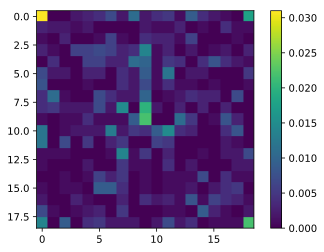

In [21]:
# adaclf is the trained adaboost classifier
adaclf = adacv.best_estimator_
fi = adaclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly for Random Forests, we can look at the important features.

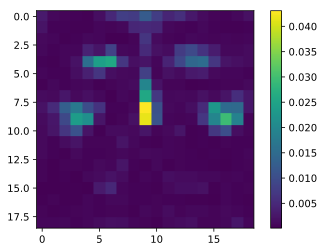

In [22]:
# rfclf is the trained random forest classifier
rfclf = rfcv.best_estimator_
fi = rfclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Comment on which features (pixels) that AdaBoost and Random Forests are using
- Adaboost seems to provide importance to very random features. Most are around the nose and face region but there are a few outliers near the corners.
- Random Forest on the other hand picks specific features like nose,eyes/eyebrows, ears and hair

For kernel SVM, we can look at the support vectors to see what the classifier finds difficult.

num support vectors: 406


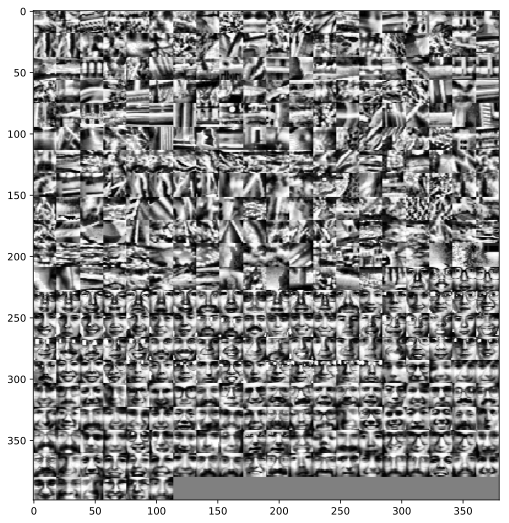

In [31]:
# svmclf is the trained SVM classifier
svmclf = rbfcv.best_estimator_
print("num support vectors:", len(svmclf.support_vectors_))
si  = svmclf.support_  # get indicies of support vectors

# get all the patches for each support vector
simg = [ imgdata['train'][i] for i in si ]

# make montage
outimg = image_montage(simg, maxw=20)

plt.figure(figsize=(9,9))
plt.imshow(outimg, cmap='gray', interpolation='nearest')

Comment on anything you notice about what the SVM finds difficult (i.e., on the decision boundary or within the margin)
- Glasses and facial hair?

## 3. Image Feature Extraction
The detection performance is not that good. The problem is that we are using the raw pixel values as features, so it is difficult for the classifier to interpret larger structures of the face that might be important.  To fix the problem, we will extract features from the image using a set of filters.

Run the below code to look at the filter output.  The filters are a sets of black and white boxes that respond to similar structures in the image.  After applying the filters to the image, the filter response map is aggregated over a 4x4 window.  Hence each filter produces a 5x5 feature response.  Since there are 4 filters, then the feature vector is 100 dimensions.

In [32]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),  
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)        
    fs = prod(tmpimg.shape)
    
    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)
            
            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.interpolation.zoom(imgk, 0.25)
    
            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)
               
            if (doplot):             
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x
    
    return X

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


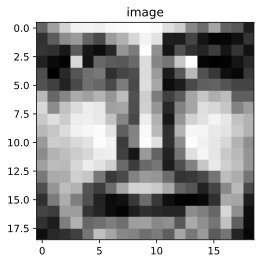

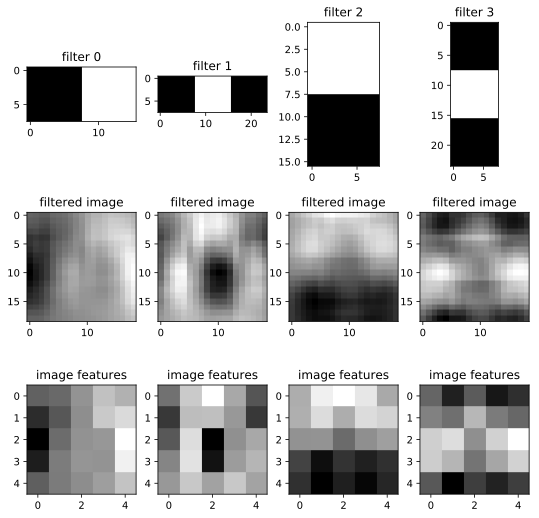

In [33]:
# new features
img = imgdata['train'][0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("image")
plt.figure(figsize=(9,9))
extract_features([img], doplot=True);

Now lets extract image features on the training and test sets.  It may take a few seconds.

In [59]:
trainXf = extract_features(imgdata['train'])
print(trainXf.shape)
testXf = extract_features(imgdata['test'])
print(testXf.shape)
minmaxscaler = preprocessing.MinMaxScaler()
trainXfn = minmaxscaler.fit_transform(trainXf)
testXfn = minmaxscaler.transform(testXf)

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(1745, 100)
(944, 100)


### Detection using Image Features
Now train AdaBoost and SVM classifiers on the image feature data.  Evaluate on the test set.

In [60]:
adacv.fit(trainXfn,trainY)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=10)]: Done  70 out of  70 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=4487),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_estimators': array([   1,    2,    3,    5,   10,   15,   20,   25,   50,  100,  200,
        500, 1000, 2000])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [61]:
predAdaY = adacv.predict(testXfn)
acc = metrics.accuracy_score(testY, predAdaY)
print("adaboost test accuracy =", acc)

adaboost test accuracy = 0.725635593220339


In [62]:
svmcv.fit(trainXfn,trainY)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   36.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'degree': [2, 3, 4], 'C': array([1.00000e-02, 3.59381e-02, 1.29155e-01, 4.64159e-01, 1.66810e+00,
       5.99484e+00, 2.15443e+01, 7.74264e+01, 2.78256e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [63]:
predPolyY = svmcv.predict(testXfn)
acc = metrics.accuracy_score(testY, predPolyY)
print("SVM Polynomial test accuracy =", acc)

SVM Polynomial test accuracy = 0.7680084745762712


In [64]:
rbfcv.fit(trainXfn,trainY)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] gamma=0.0001, C=0.01 ............................................
[CV] gamma=0.0001, C=0.01 ............................................
[CV] gamma=0.0001, C=0.01 ............................................
[CV] gamma=0.0001, C=0.01 ............................................
[CV] gamma=0.0005994842503189409, C=0.01 .............................
[CV] gamma=0.0001, C=0.01 ............................................
[CV] gamma=0.0005994842503189409, C=0.01 .............................
[CV] gamma=0.0005994842503189409, C=0.01 .............................
[CV] gamma=0.0005994842503189409, C=0.01 .............................
[CV] gamma=0.0005994842503189409, C=0.01 .............................
[CV] ............................. gamma=0.0001, C=0.01, total=   0.3s
[CV] gamma=0.003593813663804626, C=0.01 ..............................
[CV] ............................. gamma=0.0001, C=0.01, total=   0.3s
[CV] gamma=0.0

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.4s


[CV] .................. gamma=0.774263682681127, C=0.01, total=   0.3s
[CV] gamma=27.825594022071257, C=0.01 ................................
[CV] .................. gamma=4.641588833612782, C=0.01, total=   0.3s
[CV] gamma=166.81005372000593, C=0.01 ................................
[CV] .................. gamma=4.641588833612782, C=0.01, total=   0.4s
[CV] gamma=166.81005372000593, C=0.01 ................................
[CV] .................. gamma=4.641588833612782, C=0.01, total=   0.4s
[CV] .................. gamma=4.641588833612782, C=0.01, total=   0.4s
[CV] gamma=166.81005372000593, C=0.01 ................................
[CV] gamma=166.81005372000593, C=0.01 ................................
[CV] .................. gamma=4.641588833612782, C=0.01, total=   0.4s
[CV] gamma=166.81005372000593, C=0.01 ................................
[CV] ................. gamma=27.825594022071257, C=0.01, total=   0.4s
[CV] gamma=1000.0, C=0.01 ............................................
[CV] .

[CV] .. gamma=27.825594022071257, C=0.03593813663804628, total=   0.4s
[CV] gamma=1000.0, C=0.03593813663804628 .............................
[CV] .. gamma=27.825594022071257, C=0.03593813663804628, total=   0.4s
[CV] gamma=1000.0, C=0.03593813663804628 .............................
[CV] .. gamma=27.825594022071257, C=0.03593813663804628, total=   0.4s
[CV] gamma=1000.0, C=0.03593813663804628 .............................
[CV] .. gamma=166.81005372000593, C=0.03593813663804628, total=   0.4s
[CV] gamma=0.0001, C=0.1291549665014884 ..............................
[CV] .. gamma=166.81005372000593, C=0.03593813663804628, total=   0.3s
[CV] gamma=0.0001, C=0.1291549665014884 ..............................
[CV] .. gamma=166.81005372000593, C=0.03593813663804628, total=   0.4s
[CV] gamma=0.0001, C=0.1291549665014884 ..............................
[CV] .. gamma=166.81005372000593, C=0.03593813663804628, total=   0.4s
[CV] gamma=0.0001, C=0.1291549665014884 ..............................
[CV] .

[CV] ... gamma=166.81005372000593, C=0.1291549665014884, total=   0.4s
[CV] gamma=0.0005994842503189409, C=0.464158883361278 ................
[CV] ............... gamma=1000.0, C=0.1291549665014884, total=   0.3s
[CV] gamma=0.0005994842503189409, C=0.464158883361278 ................
[CV] ............... gamma=1000.0, C=0.1291549665014884, total=   0.3s
[CV] gamma=0.0005994842503189409, C=0.464158883361278 ................
[CV] ............... gamma=1000.0, C=0.1291549665014884, total=   0.3s
[CV] gamma=0.0005994842503189409, C=0.464158883361278 ................


[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    7.8s


[CV] ............... gamma=1000.0, C=0.1291549665014884, total=   0.3s
[CV] gamma=0.0005994842503189409, C=0.464158883361278 ................
[CV] ................ gamma=0.0001, C=0.464158883361278, total=   0.2s
[CV] ................ gamma=0.0001, C=0.464158883361278, total=   0.3s
[CV] gamma=0.003593813663804626, C=0.464158883361278 .................
[CV] gamma=0.003593813663804626, C=0.464158883361278 .................
[CV] ................ gamma=0.0001, C=0.464158883361278, total=   0.3s
[CV] gamma=0.003593813663804626, C=0.464158883361278 .................
[CV] ................ gamma=0.0001, C=0.464158883361278, total=   0.3s
[CV] gamma=0.003593813663804626, C=0.464158883361278 .................
[CV] ................ gamma=0.0001, C=0.464158883361278, total=   0.3s
[CV] gamma=0.003593813663804626, C=0.464158883361278 .................
[CV] . gamma=0.0005994842503189409, C=0.464158883361278, total=   0.3s
[CV] gamma=0.021544346900318846, C=0.464158883361278 .................
[CV] .

[CV]  gamma=0.0005994842503189409, C=1.6681005372000592, total=   0.3s
[CV] gamma=0.021544346900318846, C=1.6681005372000592 ................
[CV]  gamma=0.0005994842503189409, C=1.6681005372000592, total=   0.3s
[CV] gamma=0.021544346900318846, C=1.6681005372000592 ................
[CV]  gamma=0.0005994842503189409, C=1.6681005372000592, total=   0.3s
[CV] gamma=0.021544346900318846, C=1.6681005372000592 ................
[CV] . gamma=0.003593813663804626, C=1.6681005372000592, total=   0.2s
[CV] gamma=0.1291549665014884, C=1.6681005372000592 ..................
[CV] . gamma=0.021544346900318846, C=1.6681005372000592, total=   0.2s
[CV] gamma=0.1291549665014884, C=1.6681005372000592 ..................
[CV] . gamma=0.003593813663804626, C=1.6681005372000592, total=   0.2s
[CV] . gamma=0.021544346900318846, C=1.6681005372000592, total=   0.2s
[CV] gamma=0.1291549665014884, C=1.6681005372000592 ..................
[CV] gamma=0.1291549665014884, C=1.6681005372000592 ..................
[CV] .

[CV] .. gamma=0.021544346900318846, C=5.994842503189409, total=   0.1s
[CV] gamma=0.774263682681127, C=5.994842503189409 ....................
[CV] .. gamma=0.003593813663804626, C=5.994842503189409, total=   0.2s
[CV] .. gamma=0.021544346900318846, C=5.994842503189409, total=   0.1s
[CV] gamma=0.774263682681127, C=5.994842503189409 ....................
[CV] gamma=0.774263682681127, C=5.994842503189409 ....................
[CV] .. gamma=0.021544346900318846, C=5.994842503189409, total=   0.2s
[CV] gamma=0.774263682681127, C=5.994842503189409 ....................
[CV] .. gamma=0.003593813663804626, C=5.994842503189409, total=   0.2s
[CV] gamma=0.774263682681127, C=5.994842503189409 ....................
[CV] .. gamma=0.003593813663804626, C=5.994842503189409, total=   0.2s
[CV] gamma=4.641588833612782, C=5.994842503189409 ....................
[CV] .... gamma=0.1291549665014884, C=5.994842503189409, total=   0.1s
[CV] .... gamma=0.1291549665014884, C=5.994842503189409, total=   0.1s
[CV] g

[CV] ... gamma=0.1291549665014884, C=21.544346900318846, total=   0.1s
[CV] gamma=4.641588833612782, C=21.544346900318846 ...................
[CV] ... gamma=0.1291549665014884, C=21.544346900318846, total=   0.1s
[CV] gamma=4.641588833612782, C=21.544346900318846 ...................
[CV] .... gamma=0.774263682681127, C=21.544346900318846, total=   0.1s
[CV] gamma=27.825594022071257, C=21.544346900318846 ..................
[CV] .... gamma=0.774263682681127, C=21.544346900318846, total=   0.1s
[CV] gamma=27.825594022071257, C=21.544346900318846 ..................
[CV] .... gamma=0.774263682681127, C=21.544346900318846, total=   0.1s
[CV] gamma=27.825594022071257, C=21.544346900318846 ..................
[CV] .... gamma=0.774263682681127, C=21.544346900318846, total=   0.1s
[CV] gamma=27.825594022071257, C=21.544346900318846 ..................
[CV] .... gamma=0.774263682681127, C=21.544346900318846, total=   0.1s
[CV] gamma=27.825594022071257, C=21.544346900318846 ..................
[CV] .

[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   16.8s


[CV] ................ gamma=0.0001, C=77.42636826811278, total=   0.2s
[CV] gamma=0.003593813663804626, C=77.42636826811278 .................
[CV] . gamma=0.0005994842503189409, C=77.42636826811278, total=   0.2s
[CV] gamma=0.003593813663804626, C=77.42636826811278 .................
[CV] ................ gamma=0.0001, C=77.42636826811278, total=   0.2s
[CV] gamma=0.003593813663804626, C=77.42636826811278 .................
[CV] .. gamma=0.003593813663804626, C=77.42636826811278, total=   0.1s
[CV] gamma=0.003593813663804626, C=77.42636826811278 .................
[CV] ................ gamma=0.0001, C=77.42636826811278, total=   0.2s
[CV] gamma=0.021544346900318846, C=77.42636826811278 .................
[CV] . gamma=0.0005994842503189409, C=77.42636826811278, total=   0.2s
[CV] gamma=0.021544346900318846, C=77.42636826811278 .................
[CV] ................ gamma=0.0001, C=77.42636826811278, total=   0.2s
[CV] gamma=0.021544346900318846, C=77.42636826811278 .................
[CV] .

[CV] . gamma=0.0005994842503189409, C=278.2559402207126, total=   0.2s
[CV] gamma=0.021544346900318846, C=278.2559402207126 .................
[CV] ................ gamma=0.0001, C=278.2559402207126, total=   0.2s
[CV] gamma=0.1291549665014884, C=278.2559402207126 ...................
[CV] . gamma=0.0005994842503189409, C=278.2559402207126, total=   0.2s
[CV] gamma=0.1291549665014884, C=278.2559402207126 ...................
[CV] .. gamma=0.021544346900318846, C=278.2559402207126, total=   0.1s
[CV] gamma=0.1291549665014884, C=278.2559402207126 ...................
[CV] .. gamma=0.003593813663804626, C=278.2559402207126, total=   0.1s
[CV] gamma=0.1291549665014884, C=278.2559402207126 ...................
[CV] .. gamma=0.021544346900318846, C=278.2559402207126, total=   0.1s
[CV] gamma=0.1291549665014884, C=278.2559402207126 ...................
[CV] .. gamma=0.003593813663804626, C=278.2559402207126, total=   0.1s
[CV] gamma=0.774263682681127, C=278.2559402207126 ....................
[CV] .

[CV] gamma=0.774263682681127, C=1000.0 ...............................
[CV] gamma=0.774263682681127, C=1000.0 ...............................
[CV] ............. gamma=0.021544346900318846, C=1000.0, total=   0.1s
[CV] gamma=0.774263682681127, C=1000.0 ...............................
[CV] ............... gamma=0.1291549665014884, C=1000.0, total=   0.1s
[CV] gamma=0.774263682681127, C=1000.0 ...............................
[CV] ............. gamma=0.021544346900318846, C=1000.0, total=   0.1s
[CV] gamma=4.641588833612782, C=1000.0 ...............................
[CV] ............... gamma=0.1291549665014884, C=1000.0, total=   0.1s
[CV] ............. gamma=0.021544346900318846, C=1000.0, total=   0.1s
[CV] gamma=4.641588833612782, C=1000.0 ...............................
[CV] gamma=4.641588833612782, C=1000.0 ...............................
[CV] ............... gamma=0.1291549665014884, C=1000.0, total=   0.1s
[CV] gamma=4.641588833612782, C=1000.0 ...............................
[CV] .

[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   22.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'gamma': array([1.00000e-04, 5.99484e-04, 3.59381e-03, 2.15443e-02, 1.29155e-01,
       7.74264e-01, 4.64159e+00, 2.78256e+01, 1.66810e+02, 1.00000e+03]), 'C': array([1.00000e-02, 3.59381e-02, 1.29155e-01, 4.64159e-01, 1.66810e+00,
       5.99484e+00, 2.15443e+01, 7.74264e+01, 2.78256e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [65]:
predRbfY = rbfcv.predict(testXfn)
acc = metrics.accuracy_score(testY, predRbfY)
print("SVM Polynomial test accuracy =", acc)

SVM Polynomial test accuracy = 0.7203389830508474


### Error Analysis
Repeat the error analysis for the new classifiers.

In [66]:
predY = predPolyY
Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = count_nonzero(testY[Pind] == predY[Pind])
FP = count_nonzero(testY[Pind] != predY[Pind])
TN = count_nonzero(testY[Nind] == predY[Nind])
FN = count_nonzero(testY[Nind] != predY[Nind])

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)

TP= 259
FP= 213
TN= 466
FN= 6
TPR= 0.9773584905660377
FPR= 0.3136966126656848


How has the classifier using image features improved?
- The false positive rate and the true positive rate is reduced. This improves the overall accuracy.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [67]:
fname = "nasa-small.png"

(210, 480)


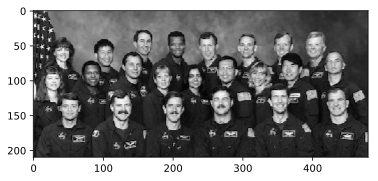

In [68]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [69]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
print(patches2.shape )

# histogram equalize patches (improves contrast)
patches3 = empty(patches2.shape)
for i in range(patches2.shape[0]):
    patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

# extract features
newXf = extract_features(patches3)

(5568, 19, 19)


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Now predict using your classifier.  The extracted features are in `newXf`.

In [73]:
newXfn  = minmaxscaler.transform(newXf)        # apply scaling to test data
prednewY = svmcv.predict(newXfn)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

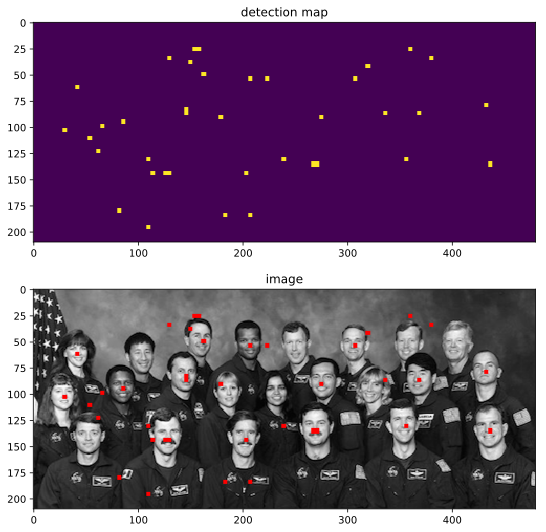

In [74]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do?_
- Detected a few faces, but a lot of false positives

- You can try it on your own images.  The faces should all be around 19x19 pixels though.
- We only used 1/4 of the training data. Try using more data to train it!